In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('seaborn-talk')
from matplotlib import cm
import numpy as np
import os
import scipy.io
import seaborn as sb
from scipy.fftpack import fft
import csv
import pandas as pd
from scipy.signal import butter, filtfilt
import glob
import seaborn as sns
from scipy import stats
from scipy import signal
from statsmodels.graphics.gofplots import qqplot, qqline
sns.set(style="ticks")

In [2]:
# Pathways
source = r"E:\Downloads\ManducaMultiSenseData\v3\Centroids_Filtered_v3"
figpath = r"E:\Downloads\ManducaMultiSenseData\Motion\Tortuosity"

In [3]:
csv_list = glob.glob(source + '/*c-3*.csv')
csv_list[0][60:]

'L0.1_c-3_m10_0_20377.csv'

In [4]:
def Tortuosity(x, time):
    
    
    t = time/100
    
    Nx = len(x)  #number of points
    Nt = Nx
    Time = t[-1]-t[0]   #total sample time (in seconds)c
    fs = Nx/Time   # sample frequency
    TT = 1/fs  #delta t.
 
    meanx = np.mean(x)
    
    # . fftxvel is complex with real and imaginary part.
    #Nyquist spacing (first half of Fourier) -- the list of frequencies for which we have Fourier coefficients
    fftx = fft(x-meanx)    # this is the Fourier tranform of the x velocity
    xf = np.linspace(0.0, 1.0/(2.0*TT), Nx//2)  

    
    return xf, Nx, fftx

In [5]:
mean_list = []
std_list = []
name_list = []
chunk = 40
trouble = []
fh_means,sh_means, fsh_means = [], [], []
fh_stds, sh_stds, fsh_stds = [], [], []
f_s_ratio_means, f_s_ratio_stds = [], []

p = 60

for ele in csv_list:
    df = pd.read_csv(ele)
   

 
        

    x, y, time = df.X_position.values, df.Y_position.values, df.FrameNumber.values #x and y positons, as well as their corresponding time steps
          
    
    # these FFTs are for the entire visit
    x_, N_, fft_ = Tortuosity(x, time) # refer to Tortuosity method above (x_ should be the x-axis going to the nyquist freq, N_ is the number of points, fft_ should be the fourier transform amplitudes)
    y_, N__, fft__ = Tortuosity(y, time) # repeat of above for y axis
    sum_ = ((2.0/N__ * np.abs(fft__[0:N__//2])) + (2.0/N_ * np.abs(fft_[0:N_//2]))) # should be linear addition of the x and y fft. As far as I remeber the 2/N_ * abs(fft_) scales the fft amplitudes from the previous line into the amplitude range of our data

# plots the fft of the entire visit
#     plt.figure(figsize=(10,6))
    
#     plt.title(ele[p:-4] + " chunk size is entire visit")
#     plt.ylim(0,15)
#     plt.ylabel("Amplitude (cm)")
#     plt.xlabel("Frequency (Hz)")
    
#     plt.plot(x_, sum_, "o")
    
#     plt.savefig(figpath + "/" + ele[p:p+5] + "/Entire_" + ele[p:-4] + ".png")
#     plt.figure(figsize=(10,6))    
    
    n = np.arange(0,len(x)-chunk,1) # a list that is as long as the number of x positions minus the chunk size
    ratio_list = []

    sum_count = chunk//2*[0] # creates a list thats as long as half the chunk size (the amount of frequencies is half the size of the chunk), full of zeros. this is going to be useful for calculating the mean amplitude later since each iteration later is going to add a value representing the amplitude one of the frequencies

    for element in n:


        shortest_path = np.sqrt((x[element+chunk]-x[element])**2 + (y[element+chunk]-y[element])**2) # this line calculates the difference between the first and last point of the chunk


        actual_list = 0
        i = 0
        while i < len(x[element:element+chunk]):

            
            #these two lines calculate the distance between each point and its neighbor (for the last point since it has no neighbor no distance is calculated)
            #these distances are summed for each point in the chunk

            actual_path = np.sqrt((x[element:element+chunk+1][i+1]-x[element:element+chunk+1][i])**2 + (y[element:element+chunk+1][i+1]-y[element:element+chunk+1][i])**2)
            actual_list += actual_path 
            



            i +=1
        
        
        
        
    
        
        

        xf, Nx, fftx = Tortuosity(x[element:element+chunk], time[element:element+chunk])  
        yf, Ny, ffty = Tortuosity(y[element:element+chunk], time[element:element+chunk])
        sum_xy = ((2.0/Ny * np.abs(ffty[0:Ny//2])) + (2.0/Nx * np.abs(fftx[0:Nx//2])))
        #these lines take an FFT of the chunk and
        
        
        sum_count += sum_xy # as mentioned above each amplitude across the represented frequencies (chunk//2) for each iterative chunk. 
        
        
#  these are plots for the chunk method FFT spectra
#         plt.title(ele[p:-4] + " chunk size is 40 frames - 10 wingbeats")
#         plt.ylim(0,15)
#         plt.ylabel("Amplitude (cm)")
#         plt.xlabel("Frequency (Hz)")
#         plt.plot(xf, sum_xy, "o", ms = 6, alpha = 0.3)


        ratio = actual_list/shortest_path # this calculates the path distance ratio 
        ratio_list.append(ratio)
    
    # this calculates the amplitude of the three frequency bands of each of the spectra
    first_half, first_s_half, second_half = sum_count[1:5]/(element), sum_count[5:10]/(element), sum_count[10:-1]/(element) 


                                                                     
    fh_means.append(np.mean(first_half)), sh_means.append(np.mean(second_half)),  fsh_means.append(np.mean(first_s_half))
    fh_stds.append(np.std(first_half)), sh_stds.append(np.std(second_half)), fsh_stds.append(np.std(first_s_half))

# plots the average amplitude of all the chunks of any given visit
#     plt.plot(xf, sum_count/(element+1), c = "c")

    name_list.append(ele[p:-4])
    finite = np.asarray(ratio_list)[~np.isinf(ratio_list)]
    mean = np.mean(finite)
    std = np.std(finite)
    mean_list.append(mean)
    std_list.append(std)
    
    
    
    if ~np.isfinite(np.mean(ratio_list)) or len(finite) < (150-chunk): # this just pulls a list of visits that are potentially false positives
        trouble.append((ele[p:-4], csv_list.index(ele), len(x), len(np.asarray(ratio_list)[~np.isfinite(ratio_list)])))
        
#     plt.savefig(figpath + "/" + ele[p:p+5] + "/mean_trace/" + ele[p:-4] + ".png")


C:\Users\guess\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\guess\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars


In [6]:
list_ = [csv_list.index(source + "\\" + element[0] + ".csv") for element in trouble]
list_path = [csv_list[element] for element in list_]

In [7]:
troubled_names = []
for element in trouble:
    troubled_names.append(element[0])

In [25]:
visit_list = []
name_list_ = []
for name in name_list:
    if name.endswith("firstVisit"):
        name = name[:-11]
        visit_list.append("F")
    else:
        name = name[:-10]
        visit_list.append("L")
    name_list_.append(name)
name_list = name_list_
len(visit_list)

110

In [63]:
condition = []
for name in name_list:
    if name.startswith("L0.1"):
        condition.append("Low")
    else:
        condition.append("High")
len(condition)

613

In [64]:
len(mean_list),len(std_list), len(name_list), len(visit_list), len(fh_means), len(sh_means), len(fh_means), len(fh_stds), len(sh_stds)

(613, 613, 613, 110, 613, 613, 613, 613, 613)

In [68]:
new_df = (pd.DataFrame({'name' : name_list, 
                        'std_tortuosity': std_list, 'mean_tortuosity' : mean_list, 
                        'first_mean_amplitude': fh_means, 'second_mean_amplitude': sh_means, 
                        'first_part2_mean_amplitude': fsh_means,
                        'condition': condition}))
new_df = new_df.sort_values(by=['name'])
new_df.reset_index(drop=True, inplace=True)
new_df.to_csv(figpath + "\\tortuosity_values_v3.csv")

In [69]:
new_df = pd.read_csv(figpath + "\\tortuosity_values_v3.csv")

In [31]:
new_df_first = new_df[new_df.visit_number == 'F']
new_df_last = new_df[new_df.visit_number == 'L']

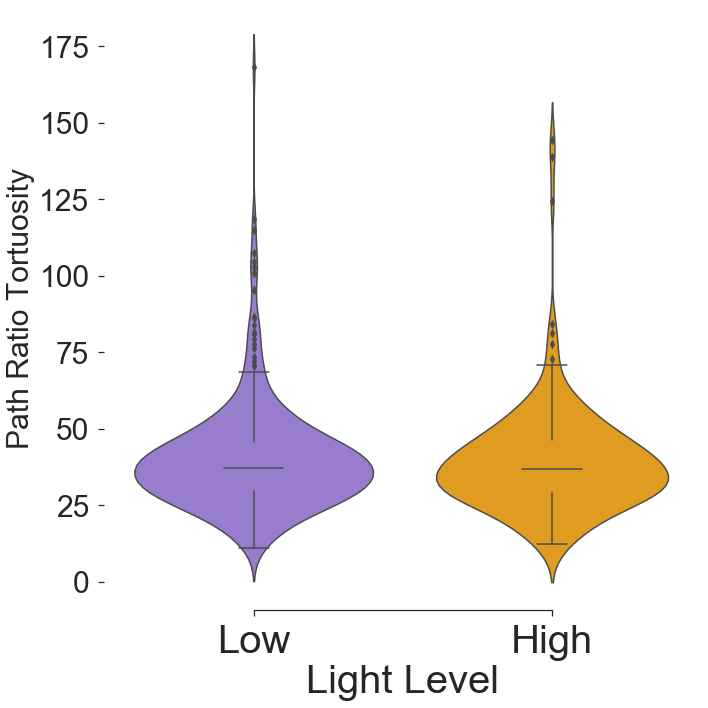

In [70]:
#I think for these guys wing beat becomes important b/c it drives the centroid moving
#need to add the original values to ground these comparisons
f, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(x="condition", y="mean_tortuosity",
                    data= new_df, inner = None,  palette=['mediumpurple','orange'])
sns.boxplot(x="condition", y="mean_tortuosity",
                    data=new_df, width = 0.2)
for tick in ax.get_yticklabels():
    tick.set_fontsize(30) 
ax.xaxis.grid(False)
ax.set_ylabel("Path Ratio Tortuosity", size = 30)
ax.set_xlabel("Light Level", size = 40)
ax.set_xticklabels(["Low","High"], size = 40)
sns.despine(trim=True, left=True)
plt.tight_layout()
# plt.savefig(figpath + "/path_ratio_tortuosity_last.png")

In [33]:
low = new_df_first[new_df_first.condition == "Low"].mean_tortuosity.values
high = new_df_first[new_df_first.condition == "High"].mean_tortuosity.values

In [34]:
low_ = new_df_last[new_df_last.condition == "Low"].mean_tortuosity.values
high_ = new_df_last[new_df_last.condition == "High"].mean_tortuosity.values

(<Figure size 748.8x514.8 with 1 Axes>, <Figure size 748.8x514.8 with 1 Axes>)

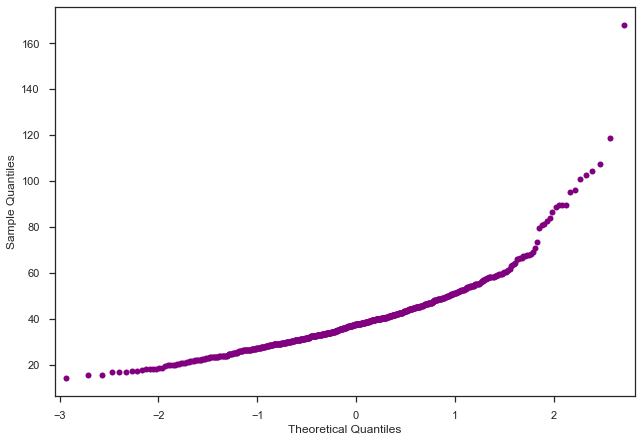

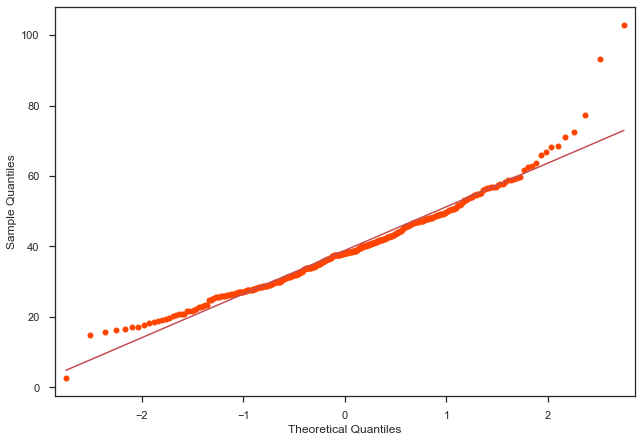

In [45]:
qqplot(low, line='s', c = "purple"), qqplot(high, line='s', c = "orangered")

C:\Users\guess\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\guess\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\guess\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\guess\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(Ks_2sampResult(statistic=0.20954907161803712, pvalue=0.4925026951995167),
 MannwhitneyuResult(statistic=373.0, pvalue=0.4764745948900613))

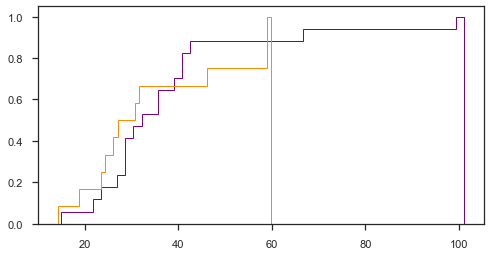

In [36]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
n_bins = 50
fig, ax = plt.subplots(figsize=(8, 4))
n, bins, patches = ax.hist(low, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical', color = 'purple')
n, bins, patches = ax.hist(high, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical', color = 'darkorange')
stats.ks_2samp(low, high), stats.mannwhitneyu(low, high)

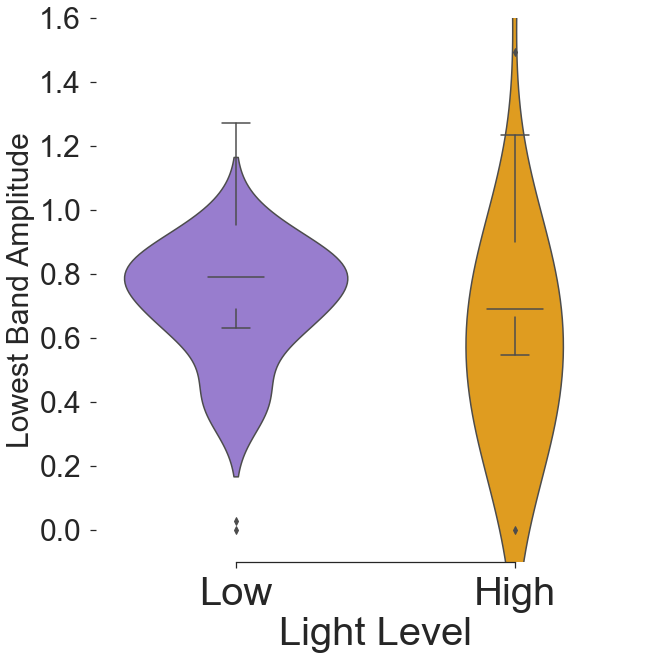

In [38]:
#need to add the original values to ground these comparisons
f, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(x="condition", y="first_mean_amplitude",
                    data= new_df_first, inner = None,  palette=['mediumpurple','orange'])
sns.boxplot(x="condition", y="first_mean_amplitude",
                    data=new_df_last, width = .2)
ax.set_ylim(-0.1,1.6)

for tick in ax.get_yticklabels():
    tick.set_fontsize(30) 
ax.xaxis.grid(False)
ax.set_ylabel("Lowest Band Amplitude", size = 30)
ax.set_xlabel("Light Level", size = 40)
ax.set_xticklabels(["Low","High"], size = 40)
sns.despine(trim=True, left=True)
# plt.savefig(figpath + "/low_band_amplitude_last.png")

In [72]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
s_f_amplitude = new_df[new_df.condition == "Low"].first_mean_amplitude.values
e_f_amplitude = new_df[new_df.condition == "High"].first_mean_amplitude.values
stats.ks_2samp(s_f_amplitude, e_f_amplitude), stats.mannwhitneyu(s_f_amplitude, e_f_amplitude)

(Ks_2sampResult(statistic=0.14396165687097678, pvalue=0.005309147493650523),
 MannwhitneyuResult(statistic=38637.0, pvalue=0.021512422504046568))

In [40]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
s_f_ = new_df_last[new_df_last.condition == "Low"].first_mean_amplitude.values
e_f_ = new_df_last[new_df_last.condition == "High"].first_mean_amplitude.values
stats.ks_2samp(s_f_, e_f_), stats.mannwhitneyu(s_f_, e_f_)

(Ks_2sampResult(statistic=0.23209549071618038, pvalue=0.37992954931533984),
 MannwhitneyuResult(statistic=361.5, pvalue=0.4001814744372808))

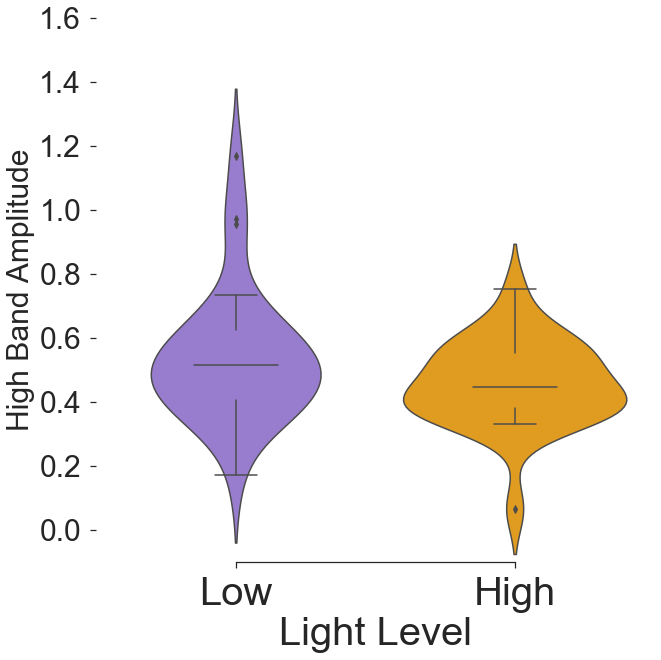

In [45]:
#need to add the original values to ground these comparisons
f, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(x="condition", y="second_mean_amplitude",
                    data= new_df_last, inner = None,  palette=['mediumpurple','orange'])
sns.boxplot(x="condition", y="second_mean_amplitude",
                    data=new_df_last, width = .3)
ax.set_ylim(-0.1,1.6)

for tick in ax.get_yticklabels():
    tick.set_fontsize(30) 
ax.xaxis.grid(False)
ax.set_ylabel("High Band Amplitude", size = 30)
ax.set_xlabel("Light Level", size = 40)
ax.set_xticklabels(["Low","High"], size = 40)
sns.despine(trim=True, left=True)
plt.savefig(figpath + "/high_band_amplitude_last.png")

In [45]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
s_s_amplitude = new_df_first[new_df_first.condition == "Low"].second_mean_amplitude.values
e_s_amplitude = new_df_first[new_df_first.condition == "High"].second_mean_amplitude.values
stats.mannwhitneyu(s_s_amplitude, e_s_amplitude)

MannwhitneyuResult(statistic=368.0, pvalue=0.4430287552735178)

In [46]:
s_s_ = new_df_last[new_df_last.condition == "Low"].second_mean_amplitude.values
e_s_ = new_df_last[new_df_last.condition == "High"].second_mean_amplitude.values
stats.mannwhitneyu(s_s_, e_s_)

MannwhitneyuResult(statistic=355.5, pvalue=0.3616588112261996)

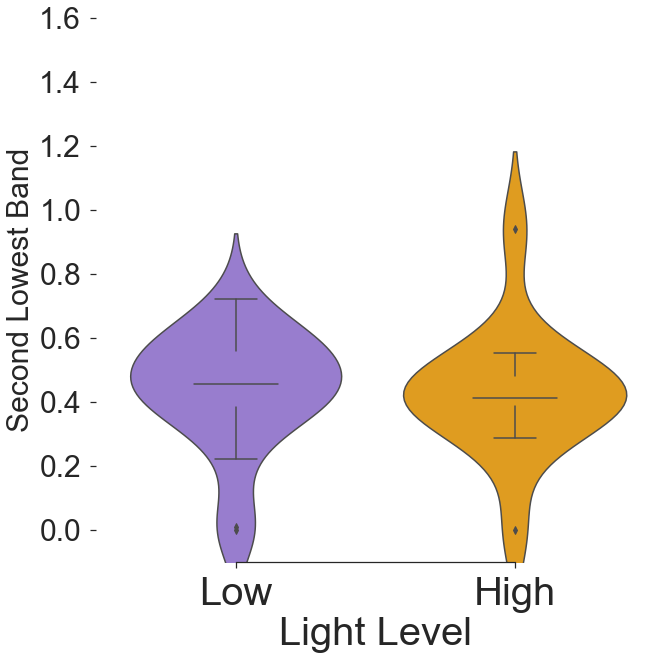

In [48]:
#need to add the original values to ground these comparisons
f, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(x="condition", y="first_part2_mean_amplitude",
                    data= new_df_last, inner = None,  palette=['mediumpurple','orange'])
sns.boxplot(x="condition", y="first_part2_mean_amplitude",
                    data= new_df_last, width = .3)

ax.set_ylim(-0.1,1.6)
for tick in ax.get_yticklabels():
    tick.set_fontsize(30) 
ax.xaxis.grid(False)
ax.set_ylabel("Second Lowest Band", size = 30)
ax.set_xlabel("Light Level", size = 40)
ax.set_xticklabels(["Low","High"], size = 40)
sns.despine(trim=True, left=True)

plt.savefig(figpath + "\second_lowest_band_last.png")

In [49]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
s_fv_amplitude = new_df_first[new_df_first.condition == "Low"].first_part2_mean_amplitude.values
e_fv_amplitude = new_df_first[new_df_first.condition == "High"].first_part2_mean_amplitude.values
stats.mannwhitneyu(s_fv_amplitude, e_fv_amplitude)

MannwhitneyuResult(statistic=339.0, pvalue=0.26363394172363763)

In [50]:
#this method assumes each data point is independent. However, even under this assumption there are no significant differences 
s_fv_ = new_df_last[new_df_last.condition == "Low"].first_part2_mean_amplitude.values
e_fv_ = new_df_last[new_df_last.condition == "High"].first_part2_mean_amplitude.values
stats.mannwhitneyu(s_fv_, e_fv_)

MannwhitneyuResult(statistic=362.5, pvalue=0.406708997099042)